In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pickle

In [3]:
!python --version

Python 3.13.5


In [4]:
pd.__version__

'2.2.3'

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

print(mlflow.get_experiment_by_name("nyc-taxi-experiment"))

2025/10/15 18:57:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/15 18:57:07 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1760438891994, experiment_id='2', last_update_time=1760438891994, lifecycle_stage='active', name='nyc-taxi-experiment', tags={'mlflow.experimentKind': 'custom_model_development'}>


In [6]:
print(mlflow.get_experiment_by_name("nyc-taxi-experiment"))

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1760438891994, experiment_id='2', last_update_time=1760438891994, lifecycle_stage='active', name='nyc-taxi-experiment', tags={'mlflow.experimentKind': 'custom_model_development'}>


In [7]:
# df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')


In [8]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.dt.total_seconds() / 60

In [9]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [10]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [11]:
df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [12]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts) 
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 221724 stored elements and shape (73908, 507)>

In [13]:
target = 'duration'
y_train = df[target].values 

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
y_pred = lr.predict(X_train)

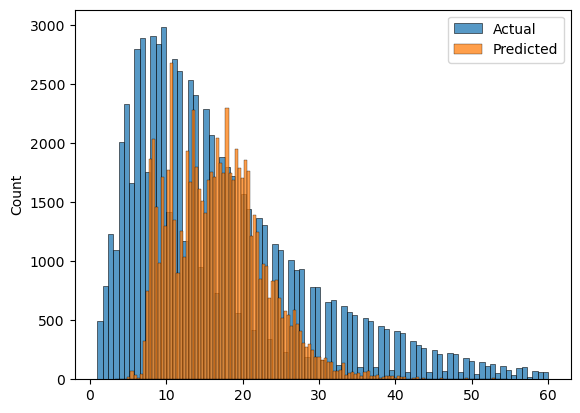

In [16]:
sns.histplot(y_train, label='Actual')
sns.histplot(y_pred, label='Predicted')
plt.legend()

In [17]:
np.sqrt(mean_squared_error(y_train, y_pred))

np.float64(9.838799799829626)

In [18]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [19]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [20]:
len(df_train), len(df_val)

(73908, 61921)

In [21]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [22]:
categorical = ['PU_DO'] 
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [23]:
target = 'duration'
y_train = df[target].values 
y_val = df_val[target].values

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

np.sqrt(mean_squared_error(y_train, y_pred))

np.float64(5.699564118198954)

In [25]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [26]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Kristof")
    mlflow.log_param("train-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact('models/lin_reg.bin', artifact_path='models_pickle')


## XGboost

In [27]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [28]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [29]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
    }

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:26:31] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.80841                          
[1]	validation-rmse:9.72547                           
[2]	validation-rmse:8.90347                           
[3]	validation-rmse:8.28478                           
[4]	validation-rmse:7.82459                           
[5]	validation-rmse:7.48517                           
[6]	validation-rmse:7.23668                           
[7]	validation-rmse:7.05422                           
[8]	validation-rmse:6.92194                           
[9]	validation-rmse:6.82347                           
[10]	validation-rmse:6.74924                          
[11]	validation-rmse:6.69426                          
[12]	validation-rmse:6.65281                          
[13]	validation-rmse:6.62000                          
[14]	validation-rmse:6.59203                          
[15]	validation-rmse:6.57037                          
[16]	validation-rmse:6.55267                          
[17]	validation-rmse:6.53864                          
[18]	valid

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:29:03] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.66178                                                      
[1]	validation-rmse:11.15901                                                      
[2]	validation-rmse:10.70045                                                      
[3]	validation-rmse:10.28380                                                      
[4]	validation-rmse:9.90560                                                       
[5]	validation-rmse:9.56327                                                       
[6]	validation-rmse:9.25326                                                       
[7]	validation-rmse:8.97433                                                       
[8]	validation-rmse:8.72194                                                       
[9]	validation-rmse:8.49588                                                       
[10]	validation-rmse:8.29188                                                      
[11]	validation-rmse:8.11156                                                      
[12]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:33:29] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.66012                                                      
[1]	validation-rmse:11.15693                                                      
[2]	validation-rmse:10.69999                                                      
[3]	validation-rmse:10.28577                                                      
[4]	validation-rmse:9.91102                                                       
[5]	validation-rmse:9.57220                                                       
[6]	validation-rmse:9.26685                                                       
[7]	validation-rmse:8.99242                                                       
[8]	validation-rmse:8.74557                                                       
[9]	validation-rmse:8.52434                                                       
[10]	validation-rmse:8.32621                                                      
[11]	validation-rmse:8.14916                                                      
[12]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:38:04] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.56447                                                       
[1]	validation-rmse:6.80592                                                       
[2]	validation-rmse:6.65888                                                       
[3]	validation-rmse:6.61476                                                       
[4]	validation-rmse:6.60251                                                       
[5]	validation-rmse:6.59455                                                       
[6]	validation-rmse:6.59024                                                       
[7]	validation-rmse:6.57797                                                       
[8]	validation-rmse:6.57425                                                       
[9]	validation-rmse:6.57134                                                       
[10]	validation-rmse:6.56582                                                      
[11]	validation-rmse:6.56330                                                      
[12]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:38:58] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.10497                                                      
[1]	validation-rmse:8.73402                                                       
[2]	validation-rmse:7.87398                                                       
[3]	validation-rmse:7.34689                                                       
[4]	validation-rmse:7.02998                                                       
[5]	validation-rmse:6.83865                                                       
[6]	validation-rmse:6.71453                                                       
[7]	validation-rmse:6.63586                                                       
[8]	validation-rmse:6.58503                                                       
[9]	validation-rmse:6.54954                                                       
[10]	validation-rmse:6.52602                                                      
[11]	validation-rmse:6.50909                                                      
[12]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:41:12] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.16067                                                       
[1]	validation-rmse:7.05098                                                       
[2]	validation-rmse:6.74875                                                       
[3]	validation-rmse:6.65092                                                       
[4]	validation-rmse:6.60937                                                       
[5]	validation-rmse:6.59018                                                       
[6]	validation-rmse:6.58013                                                       
[7]	validation-rmse:6.57526                                                       
[8]	validation-rmse:6.57027                                                       
[9]	validation-rmse:6.56502                                                       
[10]	validation-rmse:6.55998                                                      
[11]	validation-rmse:6.55561                                                      
[12]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:42:09] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.73067                                                      
[1]	validation-rmse:9.61413                                                       
[2]	validation-rmse:8.78487                                                       
[3]	validation-rmse:8.17787                                                       
[4]	validation-rmse:7.73766                                                       
[5]	validation-rmse:7.42423                                                       
[6]	validation-rmse:7.20074                                                       
[7]	validation-rmse:7.03974                                                       
[8]	validation-rmse:6.92476                                                       
[9]	validation-rmse:6.84076                                                       
[10]	validation-rmse:6.77960                                                      
[11]	validation-rmse:6.73260                                                      
[12]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:44:40] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.63309                                                      
[1]	validation-rmse:9.47955                                                       
[2]	validation-rmse:8.63328                                                       
[3]	validation-rmse:8.03028                                                       
[4]	validation-rmse:7.60578                                                       
[5]	validation-rmse:7.30185                                                       
[6]	validation-rmse:7.09845                                                       
[7]	validation-rmse:6.95510                                                       
[8]	validation-rmse:6.85116                                                       
[9]	validation-rmse:6.77266                                                       
[10]	validation-rmse:6.71833                                                      
[11]	validation-rmse:6.67506                                                      
[12]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:47:11] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.54662                                                       
[1]	validation-rmse:8.11735                                                       
[2]	validation-rmse:7.39150                                                       
[3]	validation-rmse:7.03021                                                       
[4]	validation-rmse:6.84986                                                       
[5]	validation-rmse:6.74911                                                       
[6]	validation-rmse:6.69275                                                       
[7]	validation-rmse:6.65894                                                       
[8]	validation-rmse:6.63505                                                       
[9]	validation-rmse:6.62027                                                       
[10]	validation-rmse:6.60784                                                      
[11]	validation-rmse:6.59619                                                      
[12]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:48:41] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.50345                                                      
[1]	validation-rmse:10.87261                                                      
[2]	validation-rmse:10.31468                                                      
[3]	validation-rmse:9.82172                                                       
[4]	validation-rmse:9.38868                                                       
[5]	validation-rmse:9.00806                                                       
[6]	validation-rmse:8.67266                                                       
[7]	validation-rmse:8.38156                                                       
[8]	validation-rmse:8.12675                                                       
[9]	validation-rmse:7.90591                                                       
[10]	validation-rmse:7.71385                                                      
[11]	validation-rmse:7.54758                                                      
[12]

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:53:50] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.79115                                                       
[1]	validation-rmse:11.39744                                                       
[2]	validation-rmse:11.03055                                                       
[3]	validation-rmse:10.68891                                                       
[4]	validation-rmse:10.37113                                                       
[5]	validation-rmse:10.07560                                                       
[6]	validation-rmse:9.80144                                                        
[7]	validation-rmse:9.54744                                                        
[8]	validation-rmse:9.31157                                                        
[9]	validation-rmse:9.09340                                                        
[10]	validation-rmse:8.89178                                                       
[11]	validation-rmse:8.70550                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:57:20] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.17428                                                        
[1]	validation-rmse:6.78927                                                        
[2]	validation-rmse:6.74545                                                        
[3]	validation-rmse:6.73195                                                        
[4]	validation-rmse:6.72618                                                        
[5]	validation-rmse:6.71950                                                        
[6]	validation-rmse:6.71612                                                        
[7]	validation-rmse:6.71117                                                        
[8]	validation-rmse:6.71036                                                        
[9]	validation-rmse:6.70319                                                        
[10]	validation-rmse:6.69921                                                       
[11]	validation-rmse:6.70024                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [16:58:10] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.26740                                                        
[1]	validation-rmse:7.85134                                                        
[2]	validation-rmse:7.21108                                                        
[3]	validation-rmse:6.92461                                                        
[4]	validation-rmse:6.79538                                                        
[5]	validation-rmse:6.72714                                                        
[6]	validation-rmse:6.69196                                                        
[7]	validation-rmse:6.67149                                                        
[8]	validation-rmse:6.65667                                                        
[9]	validation-rmse:6.64881                                                        
[10]	validation-rmse:6.63982                                                       
[11]	validation-rmse:6.63610                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:00:18] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.96728                                                        
[1]	validation-rmse:6.67598                                                        
[2]	validation-rmse:6.64646                                                        
[3]	validation-rmse:6.64211                                                        
[4]	validation-rmse:6.63173                                                        
[5]	validation-rmse:6.61965                                                        
[6]	validation-rmse:6.61752                                                        
[7]	validation-rmse:6.61411                                                        
[8]	validation-rmse:6.60792                                                        
[9]	validation-rmse:6.59974                                                        
[10]	validation-rmse:6.59695                                                       
[11]	validation-rmse:6.59349                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:00:50] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.35451                                                        
[1]	validation-rmse:7.18192                                                        
[2]	validation-rmse:6.84918                                                        
[3]	validation-rmse:6.73128                                                        
[4]	validation-rmse:6.67887                                                        
[5]	validation-rmse:6.65406                                                        
[6]	validation-rmse:6.63797                                                        
[7]	validation-rmse:6.62800                                                        
[8]	validation-rmse:6.62057                                                        
[9]	validation-rmse:6.61814                                                        
[10]	validation-rmse:6.61533                                                       
[11]	validation-rmse:6.61226                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:01:58] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.77049                                                    
[1]	validation-rmse:11.35852                                                    
[2]	validation-rmse:10.97551                                                    
[3]	validation-rmse:10.61957                                                    
[4]	validation-rmse:10.28963                                                    
[5]	validation-rmse:9.98353                                                     
[6]	validation-rmse:9.70027                                                     
[7]	validation-rmse:9.43845                                                     
[8]	validation-rmse:9.19638                                                     
[9]	validation-rmse:8.97326                                                     
[10]	validation-rmse:8.76716                                                    
[11]	validation-rmse:8.57709                                                    
[12]	validation-rmse:8.40244

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:10:47] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.30874                                                       
[1]	validation-rmse:10.53982                                                       
[2]	validation-rmse:9.88989                                                        
[3]	validation-rmse:9.34327                                                        
[4]	validation-rmse:8.88594                                                        
[5]	validation-rmse:8.50552                                                        
[6]	validation-rmse:8.19011                                                        
[7]	validation-rmse:7.92980                                                        
[8]	validation-rmse:7.71500                                                        
[9]	validation-rmse:7.53792                                                        
[10]	validation-rmse:7.39293                                                       
[11]	validation-rmse:7.27383                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:14:02] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.11082                                                       
[1]	validation-rmse:8.76796                                                        
[2]	validation-rmse:7.93806                                                        
[3]	validation-rmse:7.44047                                                        
[4]	validation-rmse:7.14334                                                        
[5]	validation-rmse:6.96221                                                        
[6]	validation-rmse:6.85156                                                        
[7]	validation-rmse:6.78299                                                        
[8]	validation-rmse:6.73644                                                        
[9]	validation-rmse:6.70601                                                        
[10]	validation-rmse:6.68342                                                       
[11]	validation-rmse:6.66633                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:16:35] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.15732                                                        
[1]	validation-rmse:7.71316                                                        
[2]	validation-rmse:7.07077                                                        
[3]	validation-rmse:6.79123                                                        
[4]	validation-rmse:6.66364                                                        
[5]	validation-rmse:6.59570                                                        
[6]	validation-rmse:6.55926                                                        
[7]	validation-rmse:6.53921                                                        
[8]	validation-rmse:6.52354                                                        
[9]	validation-rmse:6.51215                                                        
[10]	validation-rmse:6.50219                                                       
[11]	validation-rmse:6.49935                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:18:09] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.55939                                                        
[1]	validation-rmse:7.32463                                                        
[2]	validation-rmse:6.93081                                                        
[3]	validation-rmse:6.79897                                                        
[4]	validation-rmse:6.74700                                                        
[5]	validation-rmse:6.72898                                                        
[6]	validation-rmse:6.70605                                                        
[7]	validation-rmse:6.69917                                                        
[8]	validation-rmse:6.69513                                                        
[9]	validation-rmse:6.69188                                                        
[10]	validation-rmse:6.68910                                                       
[11]	validation-rmse:6.68460                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:19:46] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.51315                                                       
[1]	validation-rmse:10.89101                                                       
[2]	validation-rmse:10.34048                                                       
[3]	validation-rmse:9.85279                                                        
[4]	validation-rmse:9.42390                                                        
[5]	validation-rmse:9.04481                                                        
[6]	validation-rmse:8.71393                                                        
[7]	validation-rmse:8.42485                                                        
[8]	validation-rmse:8.17313                                                        
[9]	validation-rmse:7.95382                                                        
[10]	validation-rmse:7.76409                                                       
[11]	validation-rmse:7.60080                                                

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:24:51] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.20197                                                        
[1]	validation-rmse:10.35683                                                        
[2]	validation-rmse:9.65215                                                         
[3]	validation-rmse:9.06881                                                         
[4]	validation-rmse:8.58978                                                         
[5]	validation-rmse:8.19589                                                         
[6]	validation-rmse:7.87766                                                         
[7]	validation-rmse:7.62033                                                         
[8]	validation-rmse:7.41140                                                         
[9]	validation-rmse:7.24587                                                         
[10]	validation-rmse:7.10998                                                        
[11]	validation-rmse:6.99881                                     

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:28:43] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.14401                                                         
[1]	validation-rmse:10.26233                                                         
[2]	validation-rmse:9.54035                                                          
[3]	validation-rmse:8.95109                                                          
[4]	validation-rmse:8.47465                                                          
[5]	validation-rmse:8.09103                                                          
[6]	validation-rmse:7.79044                                                          
[7]	validation-rmse:7.54744                                                          
[8]	validation-rmse:7.35362                                                          
[9]	validation-rmse:7.20232                                                          
[10]	validation-rmse:7.08128                                                         
[11]	validation-rmse:6.98025                          

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:33:24] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.13722                                                         
[1]	validation-rmse:10.24982                                                         
[2]	validation-rmse:9.52019                                                          
[3]	validation-rmse:8.92262                                                          
[4]	validation-rmse:8.44084                                                          
[5]	validation-rmse:8.05388                                                          
[6]	validation-rmse:7.74472                                                          
[7]	validation-rmse:7.49594                                                          
[8]	validation-rmse:7.30103                                                          
[9]	validation-rmse:7.14596                                                          
[10]	validation-rmse:7.02019                                                         
[11]	validation-rmse:6.92105                          

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:36:50] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.34640                                                         
[1]	validation-rmse:10.59968                                                         
[2]	validation-rmse:9.95892                                                          
[3]	validation-rmse:9.41162                                                          
[4]	validation-rmse:8.94563                                                          
[5]	validation-rmse:8.55116                                                          
[6]	validation-rmse:8.21856                                                          
[7]	validation-rmse:7.93971                                                          
[8]	validation-rmse:7.70525                                                          
[9]	validation-rmse:7.50975                                                          
[10]	validation-rmse:7.34699                                                         
[11]	validation-rmse:7.21152                          

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:41:31] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.57668                                                         
[1]	validation-rmse:11.00694                                                         
[2]	validation-rmse:10.49689                                                         
[3]	validation-rmse:10.04180                                                         
[4]	validation-rmse:9.63613                                                          
[5]	validation-rmse:9.27621                                                          
[6]	validation-rmse:8.95711                                                          
[7]	validation-rmse:8.67547                                                          
[8]	validation-rmse:8.42757                                                          
[9]	validation-rmse:8.20872                                                          
[10]	validation-rmse:8.01723                                                         
[11]	validation-rmse:7.84890                          

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:43:41] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.00247                                                         
[1]	validation-rmse:10.03478                                                         
[2]	validation-rmse:9.26510                                                          
[3]	validation-rmse:8.66779                                                          
[4]	validation-rmse:8.19474                                                          
[5]	validation-rmse:7.83668                                                          
[6]	validation-rmse:7.55890                                                          
[7]	validation-rmse:7.34222                                                          
[8]	validation-rmse:7.17726                                                          
[9]	validation-rmse:7.04616                                                          
[10]	validation-rmse:6.94965                                                         
[11]	validation-rmse:6.87457                          

/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [17:47:01] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



: 

In [ ]:
mlflow.xgboost.autolog()

In [30]:
with mlflow.start_run():
    best_params = {
        'max_depth': 0,
        'learning_rate': 0,
        'reg_alpha': 0,
        'reg_lambda': 0,
        'min_child_weight': 0,
        'objective': 'reg:linear',
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


/home/codespace/anaconda3/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [18:58:15] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


: 